# 0. Importando as Bibliotecas e o DataFrame

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [ ]:
# para manipulação de dados
import pandas as pd
import numpy as np

# Para visualizações de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Para cálculos estatísticos
from scipy import stats

# Para cálculos matemáticos
from math import floor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Métricas de avaliação do Modelo
from sklearn.metrics import (precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             confusion_matrix,
                             auc)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

pd.options.plotting.backend = "plotly"
colors = ['royalblue','midnightblue']

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregando o Dataset
transactions = pd.read_csv('datasets/creditcard.csv')

# 1. Criando Funções que iremos utilizar

In [ ]:
# Criar funções para plotar o resultado do modelo
def modelo(clf, X_train, y_train, X_val, y_val, threshold=0.5):
    # Treina o modelo
    clf.fit(X_train, y_train)

    # Realiza previsão de acorodo com o thresholde especificado
    y_pred = (clf.predict_proba(X_val)[:, 1] > threshold)
    y_pre_proba = clf.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_pre_proba)

    fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 27)
    score = cross_val_score(clf, X_train, y_train, cv = fold, scoring = 'roc_auc', n_jobs = -1).mean()

    # Mostrando o desempenho do modelo
    print(f"Score Cross Validation: {score:.2%}")
    print(f"Average Precision: {average_precision_score(y_val, y_pre_proba):.2%}")
    print(f"Precision Score: {precision_score(y_val, y_pred):.2%}")
    print(f"Recall Score: {recall_score(y_val, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_val, y_pred):.2%}")
    print(f"AUCPR: {auc(recall, precision):.2%}")
    print(f"ROC AUC Score: {roc_auc_score(y_val, y_pred):.2%}")

In [ ]:
def plot_recall_precision_curve(clf, X, y, name_clf=None):
    y_pred_proba = clf.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    aucpr = auc(recall, precision)
    
    if not(name_clf):
        name_clf = 'Classifier'

    fig, ax = plt.subplots()
    ax.plot(precision, recall, label = name_clf)
    ax.set_title(f"AUCPR = {aucpr:.2%}")
    ax.set_xlabel('Precision')
    ax.set_ylabel('Recall')
    ax.legend()
    ax.grid()

In [ ]:
# Criar a matriz de confusão
def matriz_confusao(clf, X_test, y_test):
    cm = confusion_matrix(y_test, clf.predict(X_test))
    nomes = ['Verdadeiro Neg.','Falso Pos.','Falso Neg.','Verdadeiro Pos.']
    counts = [value for value in cm.flatten()]
    porcentagens = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nomes, counts, porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (12, 7))
    sns.heatmap(cm, annot = labels, cmap = 'Blues', fmt ='')
    plt.show();

# 2. Explorando o Dataset

In [ ]:
# Visualizando as 5 primeiras linhas
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Formato do datatset
rows, cols = transactions.shape

print(f'N° de Instâncias = {rows} \nN° de features = {cols}')

N° de Instâncias = 284807 
N° de features = 31


In [ ]:
# Nome das features
transactions.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
# informações sobre os tipo das features do dataset
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Verificando se temos dados duplicados
duplicated = transactions.duplicated()

# Visualizando os dados duplicados
transactions[duplicated].head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0


In [ ]:
count_duplicated = duplicated.sum()
prop_duplicated = count_duplicated/rows

print(f'Temos, {count_duplicated} instâncias duplicadas. Isso representa {prop_duplicated:.2%} do total de instâncias.')

Temos, 1081 instâncias duplicadas. Isso representa 0.38% do total de instâncias.


In [ ]:
# Removendo os dados duplicados
transactions = transactions.drop_duplicates()

In [ ]:
# Formato do datatset após remover dados duplicados
rows_now, cols_now = transactions.shape

print(f'Antes: ({rows}, {cols})')
print(f'Agora: ({rows_now}, {cols_now})')

Antes: (284807, 31)
Agora: (283726, 31)


In [ ]:
# Verificando se há valores nulos
transactions.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,283726.0,94811.077600,47481.047891,0.000000,54204.750000,84692.500000,139298.000000,172792.000000
V1,283726.0,0.005917,1.948026,-56.407510,-0.915951,0.020384,1.316068,2.454930
V2,283726.0,-0.004135,1.646703,-72.715728,-0.600321,0.063949,0.800283,22.057729
V3,283726.0,0.001613,1.508682,-48.325589,-0.889682,0.179963,1.026960,9.382558
V4,283726.0,-0.002966,1.414184,-5.683171,-0.850134,-0.022248,0.739647,16.875344
V5,283726.0,0.001828,1.377008,-113.743307,-0.689830,-0.053468,0.612218,34.801666
V6,283726.0,-0.001139,1.331931,-26.160506,-0.769031,-0.275168,0.396792,73.301626
V7,283726.0,0.001801,1.227664,-43.557242,-0.552509,0.040859,0.570474,120.589494
V8,283726.0,-0.000854,1.179054,-73.216718,-0.208828,0.021898,0.325704,20.007208
V9,283726.0,-0.001596,1.095492,-13.434066,-0.644221,-0.052596,0.595977,15.594995


## Dividindo o conjunto em Treino e Teste

In [ ]:
X = transactions.drop(['Class'], axis=1)
y = transactions['Class']

In [ ]:
# Dividindo o conjunto em treino e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=27)

In [ ]:
#Validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=27)

In [ ]:
# Copiando os datasets originais
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [ ]:
# Formato dos dados de treino e teste
print('Treino:    ', X_train.shape, y_train.shape)
print('Validação: ', X_val.shape, y_val.shape)
print('Teste:     ', X_test.shape, y_test.shape)

Treino:     (170235, 30) (170235,)
Validação:  (56745, 30) (56745,)
Teste:      (56746, 30) (56746,)


In [ ]:
# Proporção do Target em cada conjunto
prop = pd.DataFrame({"Treino":y_train.value_counts(1), "Validação":y_val.value_counts(1), "Teste":y_test.value_counts(1)})
prop

,Treino,Validação,Teste
Class,,,
0,0.998338,0.998326,0.998326
1,0.001662,0.001674,0.001674


In [ ]:
# Juntando os dados de treino em um dataframe
df_train = X_train.merge(y_train, how= 'inner', left_index=True, right_index=True)

# 3. EDA (Análise Exploratória de Dados)

In [ ]:
group_amount_by_class = df_train[['Class', 'Amount']].groupby(by=['Class']).describe()

In [ ]:
group_amount_by_class

Amount                                                            
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      169952.0   88.733896  252.368266  0.0  5.77  22.04   77.89  25691.16
1         283.0  112.125760  220.546882  0.0  1.00   7.61  104.42   1504.93

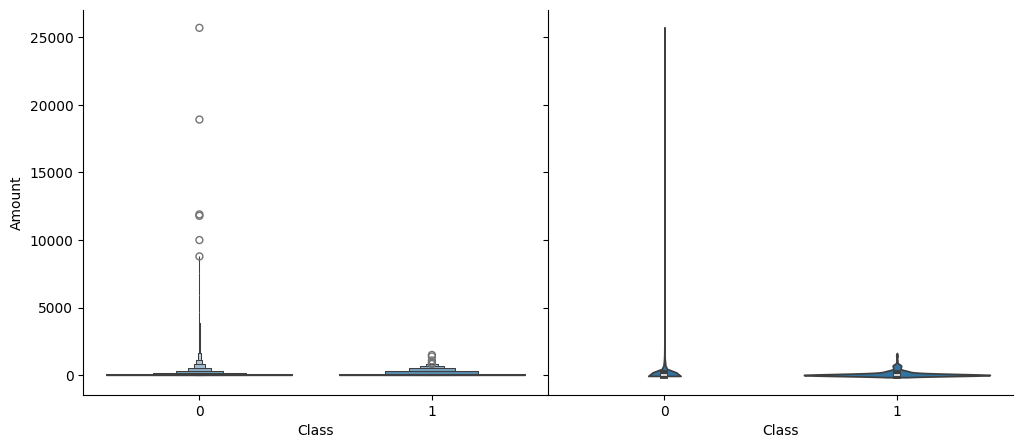

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
sns.boxenplot(data=df_train, y='Amount', x='Class', ax=ax[0])
sns.violinplot(data=df_train, y='Amount', x='Class', ax=ax[1])

plt.subplots_adjust(wspace=0)
sns.despine()

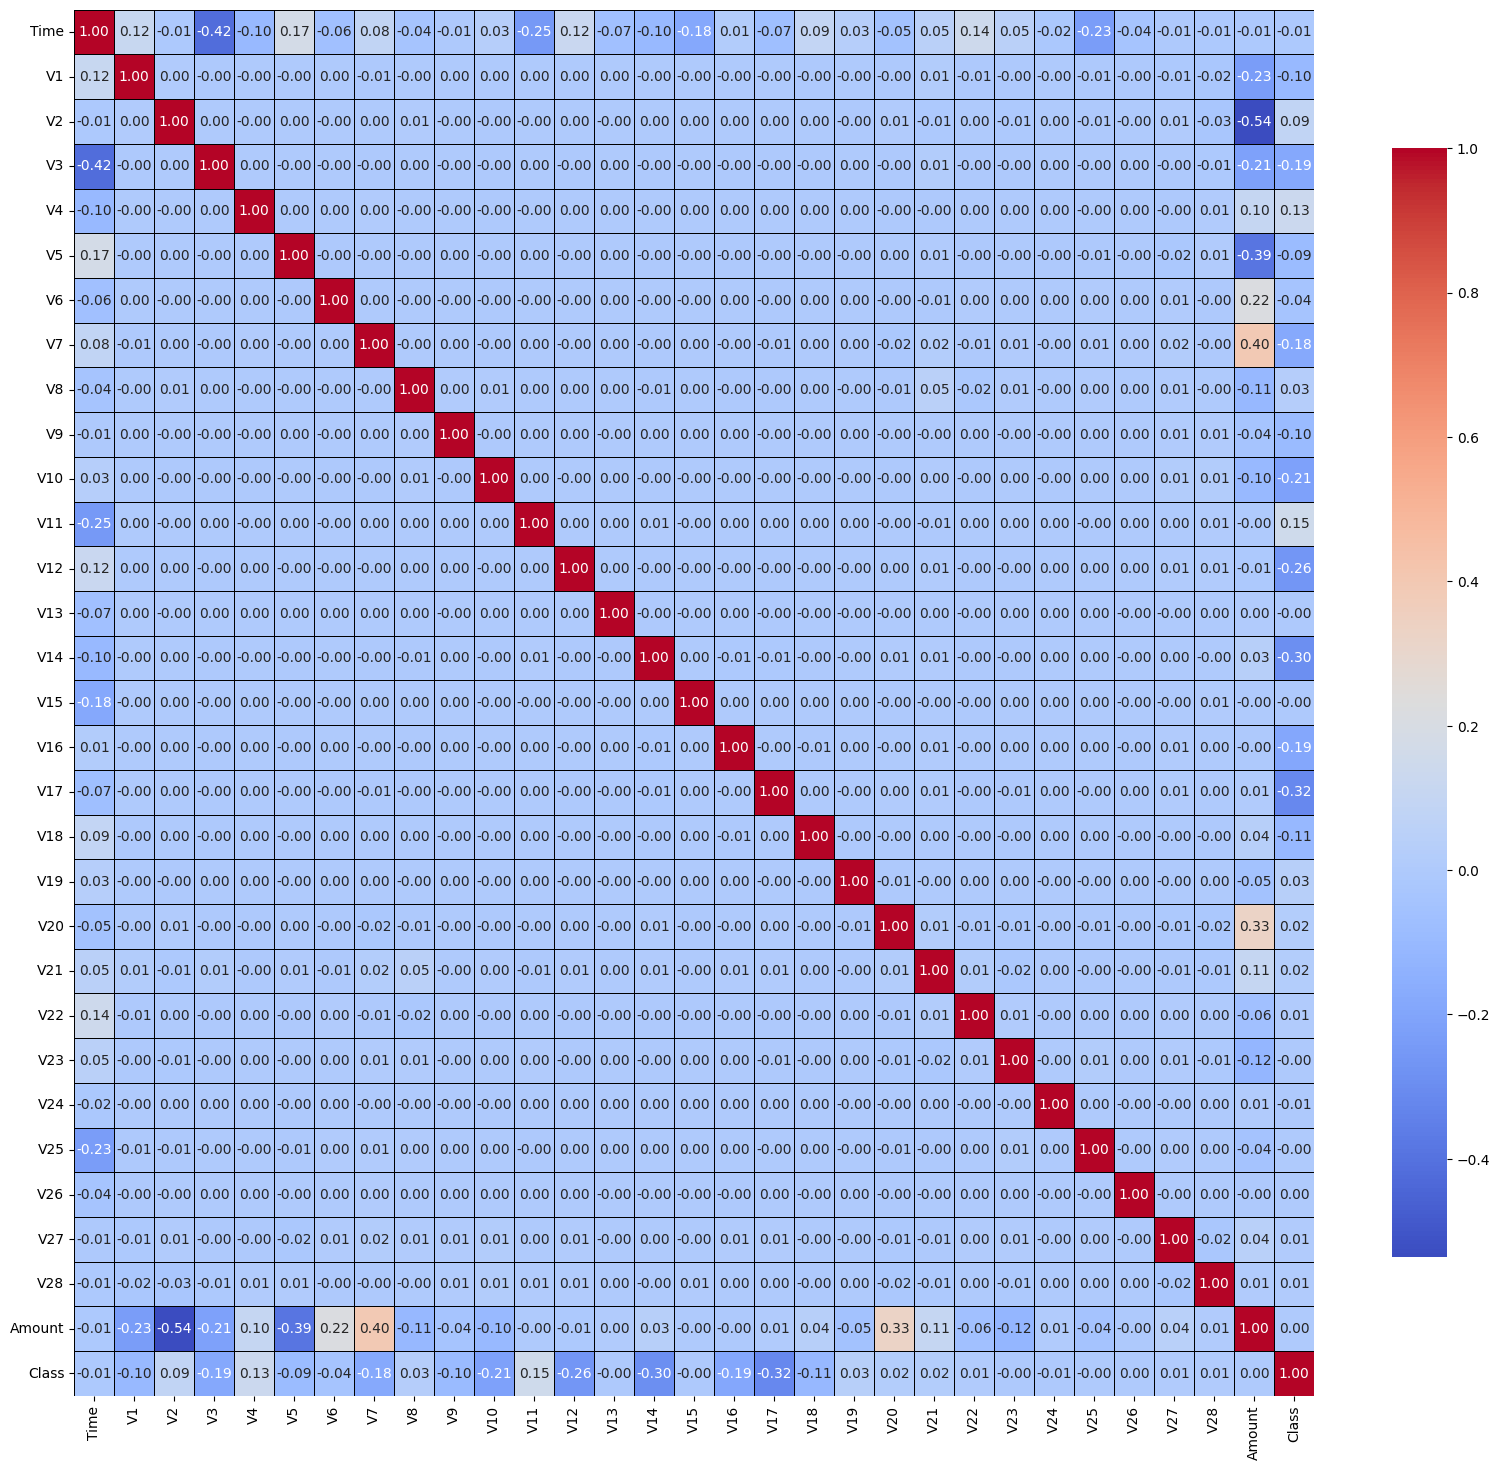

In [ ]:
plt.figure(figsize=(20, 18))
#Matriz de Correlação
correlation = df_train.corr(method='pearson')

# Heatmap com rotação nos rótulos
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='black', xticklabels=correlation.columns, yticklabels=correlation.columns, cbar_kws={"shrink": 0.8})

# Espaçamento entre os rótulos
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

Observações importantes: <br>
    **1** - Analisando a variável `Amount`, observamos que as médias dos *valores de transações* são diferentes entre as classes **Fraude** e **Não-Fraude**. Sendo mais especifico, as transações classificadas como fraudes tendem a apresentar um valor mpedio mais alto comparado às transações não fraudulentas. Essa diferença sugere que as transações de valor mais alto têm uma maior probabilidade de serem fraudulentas. No entanto, vimos que existe transações, que mesmo não sendo classificadas como fraudulentas, possuem valores bem altos. Basta olhar os valores máximos de cada classe.<br>
    **2** - As correlações entre as features possuem intensidade de fraca(grande maioria) a moderada.

In [ ]:
# Separando os dados em Fraude e Não-Fraude
fraud = df_train[df_train['Class'] == 1]['Amount']
non_fraud = df_train[df_train['Class'] == 0]['Amount']

# Calculando as médias
mean_fraud = fraud.mean()
mean_non_fraud = non_fraud.mean()

print(f'Média das transações fraudulentas: {mean_fraud:.2f}')
print(f'Média das transações Não-fraudulentas: {mean_non_fraud:.2f}')

# Realizando o teste t de Student
t_stat, p_value = stats.ttest_ind(fraud, non_fraud)

print(f'T-statistic: {t_stat:.3f}')
print(f'P-value: {p_value:.2f}')

# Fazendo a afirmação com base no p-valor
alpha = 0.05
if p_value < alpha:
    print("As médias de Amount são significativamente diferentes entre Fraude e Não-Fraude.")
else:
    print("Não há evidências suficientes para afirmar que as médias de Amount são diferentes entre Fraude e Não-Fraude.")


Média das transações fraudulentas: 112.13
Média das transações Não-fraudulentas: 88.73
T-statistic: 1.558
P-value: 0.12
Não há evidências suficientes para afirmar que as médias de Amount são diferentes entre Fraude e Não-Fraude.


# 4. Modelagem

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

weight = y_train.value_counts(1)[0]/y_train.value_counts(1)[1]

## 4.1 Testando Modelos

### XGBoost Classifier

In [ ]:
# Parâmetros do modelo
params_xgb = {
  'n_estimators':200,
  'max_depth':7,
  }

# Instânciando o modelo
clf_xgb = XGBClassifier(scale_pos_weight=weight, random_state=27)

In [ ]:
modelo(clf_xgb, X_train, y_train, X_val, y_val)

Score Cross Validation: 97.29%
Average Precision: 86.73%
Precision Score: 91.67%
Recall Score: 81.05%
F1 Score: 86.03%
AUCPR: 86.72%
ROC AUC Score: 90.52%


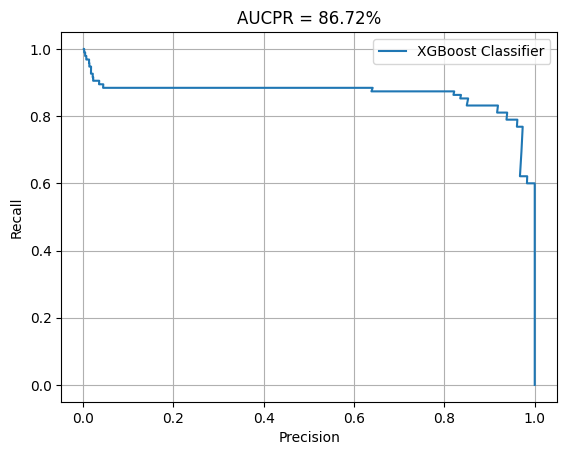

In [ ]:
plot_recall_precision_curve(clf_xgb, X_val, y_val, name_clf='XGBoost Classifier')

In [ ]:
# Avaliando o desempenho no conjunto de teste
modelo(clf_xgb, X_train, y_train, X_test, y_test)

Score Cross Validation: 97.29%
Average Precision: 85.56%
Precision Score: 91.76%
Recall Score: 82.11%
F1 Score: 86.67%
AUCPR: 85.55%
ROC AUC Score: 91.05%


### LightGBM Classifier

In [ ]:
params_lgbm = {
  'n_estimators':200,
  'num_leaves':50,
  'max_depth':15,
  'learning_rate':0.02,
  'verbosity':-1
  }

# Instânciando o modelo
clf_lgbm = LGBMClassifier(**params_lgbm, scale_pos_weight=weight, random_state=27)

In [ ]:
# Avaliando o desempenho no conjunto de validação para
modelo(clf_lgbm, X_train, y_train, X_val, y_val)

Score Cross Validation: 89.48%
Average Precision: 81.93%
Precision Score: 70.27%
Recall Score: 82.11%
F1 Score: 75.73%
AUCPR: 81.92%
ROC AUC Score: 91.02%


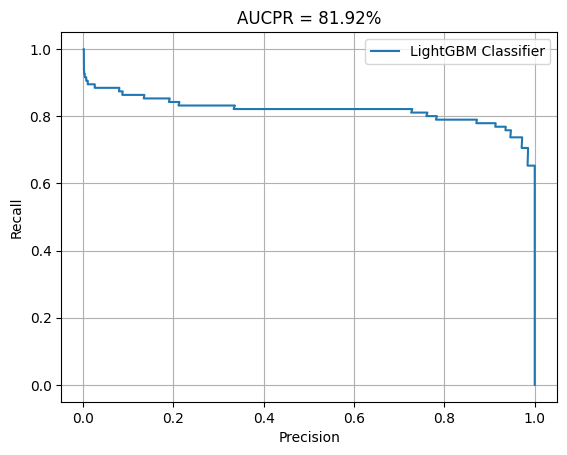

In [ ]:
plot_recall_precision_curve(clf_lgbm, X_val, y_val, name_clf='LightGBM Classifier')

In [ ]:
# Avaliando o desempenho no conjunto de teste
modelo(clf_lgbm, X_train, y_train, X_test, y_test)

Score Cross Validation: 89.48%
Average Precision: 82.15%
Precision Score: 77.23%
Recall Score: 82.11%
F1 Score: 79.59%
AUCPR: 82.14%
ROC AUC Score: 91.03%


### CatBoost Classifier

In [ ]:
# Parâmetros do modelo
params_cat = {
    'n_estimators':200,
    'max_depth':7,
    'min_child_samples':50,
    'learning_rate':0.1
    }

# Instânciando o modelo
clf_cat = CatBoostClassifier(**params_cat, auto_class_weights='Balanced', random_state=27, verbose=False, thread_count=4)

In [ ]:
# Treinando modelo
modelo(clf_cat, X_train, y_train, X_val, y_val)

Score Cross Validation: 97.47%
Average Precision: 86.42%
Precision Score: 82.00%
Recall Score: 86.32%
F1 Score: 84.10%
AUCPR: 86.40%
ROC AUC Score: 93.14%


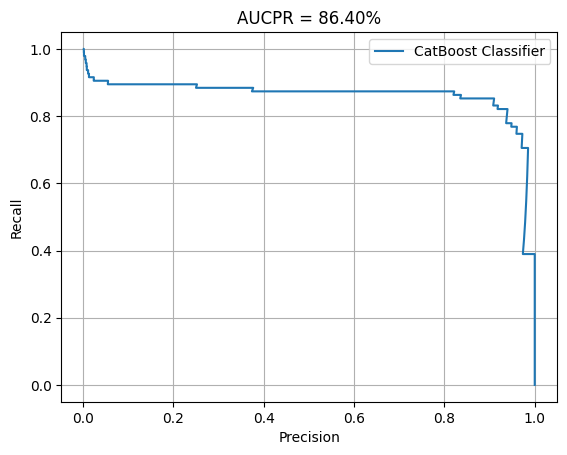

In [ ]:
plot_recall_precision_curve(clf_cat, X_val, y_val, name_clf='CatBoost Classifier')

In [ ]:
# Avaliando o desempenho no conjunto de teste
modelo(clf_cat, X_train, y_train, X_test, y_test)

Score Cross Validation: 97.47%
Average Precision: 86.98%
Precision Score: 83.00%
Recall Score: 87.37%
F1 Score: 85.13%
AUCPR: 86.98%
ROC AUC Score: 93.67%


###  Regressão logística

In [ ]:
# Parâmetros do modelo
params_log = {
    'class_weight':'balanced',
    'solver':'lbfgs',
    'max_iter':500}

# Instânciando o modelo
clf_log = LogisticRegression(**params_log, C=0.5, random_state=27)

In [ ]:
modelo(clf_log, X_train, y_train, X_val, y_val)

Score Cross Validation: 96.91%
Average Precision: 71.04%
Precision Score: 3.51%
Recall Score: 90.53%
F1 Score: 6.76%
AUCPR: 70.90%
ROC AUC Score: 93.18%


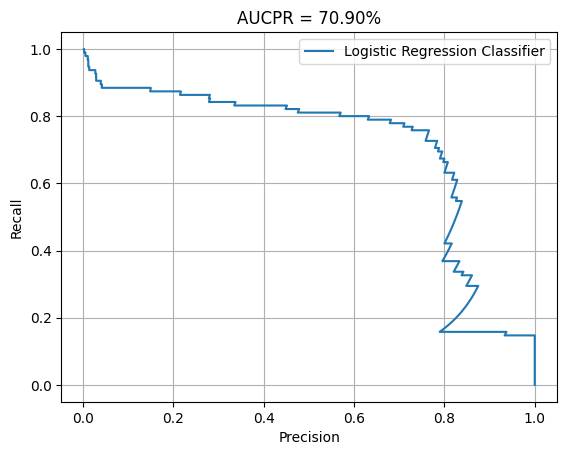

In [ ]:
plot_recall_precision_curve(clf_log, X_val, y_val, name_clf='Logistic Regression Classifier')

In [ ]:
# Avaliando o desempenho no conjunto de teste
modelo(clf_log, X_train, y_train, X_test, y_test)

Score Cross Validation: 96.91%
Average Precision: 63.97%
Precision Score: 3.67%
Recall Score: 91.58%
F1 Score: 7.05%
AUCPR: 64.99%
ROC AUC Score: 93.77%


### HistGradientBoostingClassifier

In [ ]:
params_hbc = {
    'max_depth':12,
    'learning_rate':0.01,
    'min_samples_leaf':10,
    }

# Criando o modelo
clf_hbc = HistGradientBoostingClassifier(**params_hbc, class_weight='balanced', random_state=27)

In [ ]:
# Avaliação do desempenho
modelo(clf_hbc, X_train, y_train, X_val, y_val)

Score Cross Validation: 91.80%
Average Precision: 65.16%
Precision Score: 20.66%
Recall Score: 85.26%
F1 Score: 33.26%
AUCPR: 74.25%
ROC AUC Score: 92.36%


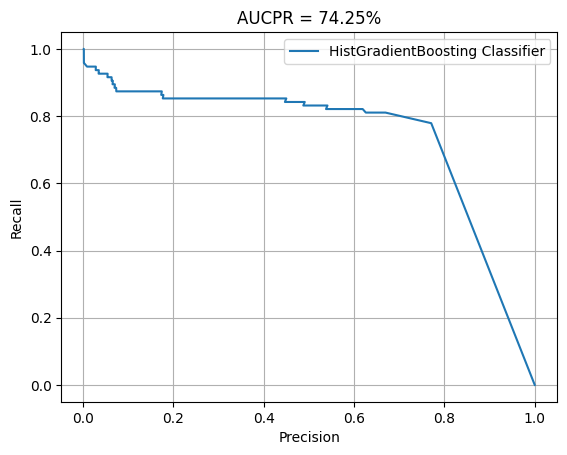

In [ ]:
plot_recall_precision_curve(clf_hbc, X_val, y_val, name_clf='HistGradientBoosting Classifier')

In [ ]:
# Avaliação no conjutno de teste
modelo(clf_hbc, X_train, y_train, X_test, y_test)

Score Cross Validation: 91.80%
Average Precision: 64.21%
Precision Score: 22.07%
Recall Score: 83.16%
F1 Score: 34.88%
AUCPR: 73.20%
ROC AUC Score: 91.33%


### Decision Tree Classifier

In [ ]:
params_tree = {
    'max_depth':15,
    'min_samples_split': 10,
    'min_samples_leaf': 5
    }

# Instânciando o modelo
clf_tree = DecisionTreeClassifier(**params_tree, class_weight='balanced', random_state=27)

In [ ]:
# Avaliação do desempenho
modelo(clf_tree, X_train, y_train, X_val, y_val)

Score Cross Validation: 88.13%
Average Precision: 74.49%
Precision Score: 36.20%
Recall Score: 84.21%
F1 Score: 50.63%
AUCPR: 81.34%
ROC AUC Score: 91.98%


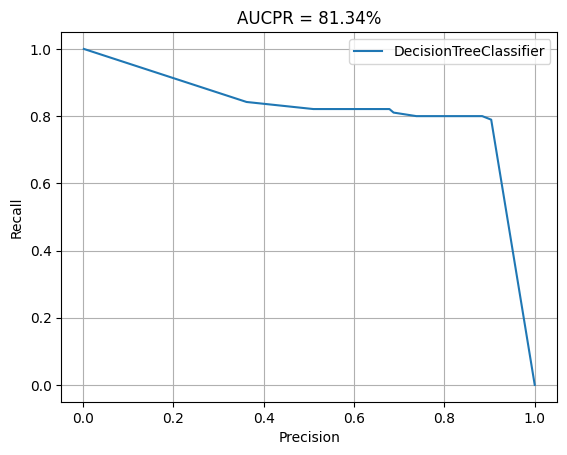

In [ ]:
plot_recall_precision_curve(clf_tree, X_val, y_val, name_clf='DecisionTreeClassifier')

In [ ]:
# Avaliação no conjutno de teste
modelo(clf_tree, X_train, y_train, X_test, y_test)

Score Cross Validation: 88.13%
Average Precision: 66.82%
Precision Score: 35.82%
Recall Score: 75.79%
F1 Score: 48.65%
AUCPR: 74.93%
ROC AUC Score: 87.78%


## 4.2 Turnagem de Hiperparâmetros

* Após avaliar o desempenho de cada modelo no conjunto de teste, optei por selecionar os 3 melhores modelos, com base nos seguintes critérios:
  - 1) Desempenhos parecidos e bons no conjunto de treino e teste, sendo medidos pela ROC AUC;
  - 2) Possíveis pontos de melhorias apresentados no cojunto de validação. Nesse caso, olhei para a métrica AUCPR. Basicamente, ela indica possíveis pontos de melhorias entre Precision x Recall.

* Os modelos escolhidos foram:
  - 1) XGBoost Classifier
  - 2) LightGBMBoost Classifier
  - 3) CatBoost Classifier


### XGBoost Classifier Turning

In [ ]:
def objective_xgb(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 0.95, step=0.05)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.95, step=0.05)
    min_child_weight = trial.suggest_int('min_child_weight', 5, 150)

    turn_params = {
        'n_estimators':n_estimators,
        'max_depth':max_depth,
        'learning_rate':learning_rate,
        'min_child_weight': min_child_weight,
        'subsample':subsample,
        'colsample_bytree':colsample_bytree
        }

    clf = XGBClassifier(**turn_params, scale_pos_weight=weight, random_state=27)
    clf.fit(X_train, y_train)

    score = f1_score(y_val, clf.predict(X_val))
    # score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

    return score

In [ ]:
study_xgb = optuna.create_study(direction = 'maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2024-07-26 17:52:51,685] A new study created in memory with name: no-name-9aac2f1d-b79d-463d-b372-ebc8643d87b9
[I 2024-07-26 17:52:56,831] Trial 0 finished with value: 0.20531400966183574 and parameters: {'n_estimators': 27, 'max_depth': 3, 'learning_rate': 0.00884315855052487, 'subsample': 0.55, 'colsample_bytree': 0.5, 'min_child_weight': 46}. Best is trial 0 with value: 0.20531400966183574.
[I 2024-07-26 17:53:13,981] Trial 1 finished with value: 0.6536964980544747 and parameters: {'n_estimators': 311, 'max_depth': 13, 'learning_rate': 0.012535222930401114, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.6, 'min_child_weight': 98}. Best is trial 1 with value: 0.6536964980544747.
[I 2024-07-26 17:53:15,583] Trial 2 finished with value: 0.6919831223628692 and parameters: {'n_estimators': 22, 'max_depth': 40, 'learning_rate': 0.002720298284832524, 'subsample': 0.55, 'colsample_bytree': 0.5, 'min_child_weight': 68}. Best is trial 2 with value: 0.6919831223628692.
[I 2024-07-26

In [ ]:
best_params_xgb = study_xgb.best_params
print(best_params_xgb)

{'n_estimators': 495, 'max_depth': 13, 'learning_rate': 0.056660271915512, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.55, 'min_child_weight': 5}


In [ ]:
clf_xgb_turn = XGBClassifier(**best_params_xgb, scale_pos_weight=weight, random_state=27)

In [ ]:
modelo(clf_xgb_turn, X_train, y_train, X_val, y_val)

Score Cross Validation: 98.55%
Average Precision: 87.24%
Precision Score: 93.10%
Recall Score: 85.26%
F1 Score: 89.01%
AUCPR: 87.23%
ROC AUC Score: 92.63%


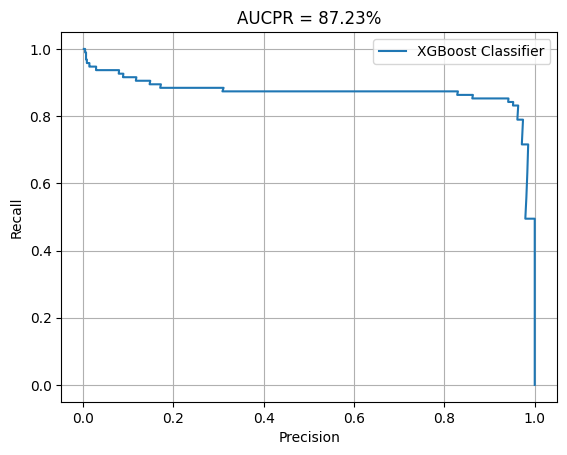

In [ ]:
plot_recall_precision_curve(clf_xgb_turn, X_val, y_val, name_clf='XGBoost Classifier')

In [ ]:
modelo(clf_xgb_turn, X_train, y_train, X_test, y_test)

Score Cross Validation: 98.55%
Average Precision: 87.03%
Precision Score: 91.01%
Recall Score: 85.26%
F1 Score: 88.04%
AUCPR: 87.03%
ROC AUC Score: 92.62%


### LightGBM Classifier Turning

In [ ]:
def objective_lgbm(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 6, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    num_leaves = trial.suggest_int('num_leaves', 31, 60)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 200)
    subsample = trial.suggest_float('subsample', 0.5, 0.95, step=0.05)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.4, 0.8, step=0.05)

    params = {
        'n_estimators':n_estimators,
        'max_depth':max_depth,
        'learning_rate':learning_rate,
        'subsample':subsample,
        'min_data_in_leaf':min_data_in_leaf,
        'num_leaves':num_leaves,
        'colsample_bytree':colsample_bytree,
        }

    clf = LGBMClassifier(**params, is_unbalance=True, verbosity=-1, random_state = 27)
    clf.fit(X_train, y_train)

    score = f1_score(y_val, clf.predict(X_val))
    # score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

    return score

In [ ]:
study_lgbm = optuna.create_study(direction = 'maximize')
study_lgbm.optimize(objective_lgbm, n_trials=100)

[I 2024-07-26 18:26:04,749] A new study created in memory with name: no-name-0591d3ad-ce31-4e2d-ab23-19ae6599c126
[I 2024-07-26 18:26:11,199] Trial 0 finished with value: 0.32684824902723736 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.004732900058244881, 'num_leaves': 34, 'min_data_in_leaf': 71, 'subsample': 0.65, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.32684824902723736.
[I 2024-07-26 18:26:26,044] Trial 1 finished with value: 0.7668393782383419 and parameters: {'n_estimators': 342, 'max_depth': 19, 'learning_rate': 0.026260083554743376, 'num_leaves': 43, 'min_data_in_leaf': 117, 'subsample': 0.8, 'colsample_bytree': 0.65}. Best is trial 1 with value: 0.7668393782383419.
[I 2024-07-26 18:26:34,860] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 161, 'max_depth': 18, 'learning_rate': 0.0031030262710892227, 'num_leaves': 51, 'min_data_in_leaf': 62, 'subsample': 0.7, 'colsample_bytree': 0.75}. Best is trial 1 with value: 0.7

In [ ]:
best_params_lgmb = study_lgbm.best_params
print(best_params_lgmb)

{'n_estimators': 457, 'max_depth': 16, 'learning_rate': 0.018856604684840253, 'num_leaves': 52, 'min_data_in_leaf': 62, 'subsample': 0.8500000000000001, 'colsample_bytree': 0.7000000000000001}


In [ ]:
# Criação do modelo
clf_lgbm_turn = LGBMClassifier(**best_params_lgmb, is_unbalance=True, random_state = 27, verbosity=-1)

In [ ]:
modelo(clf_lgbm_turn, X_train, y_train, X_val, y_val)

Score Cross Validation: 92.92%
Average Precision: 85.37%
Precision Score: 95.24%
Recall Score: 84.21%
F1 Score: 89.39%
AUCPR: 85.36%
ROC AUC Score: 92.10%


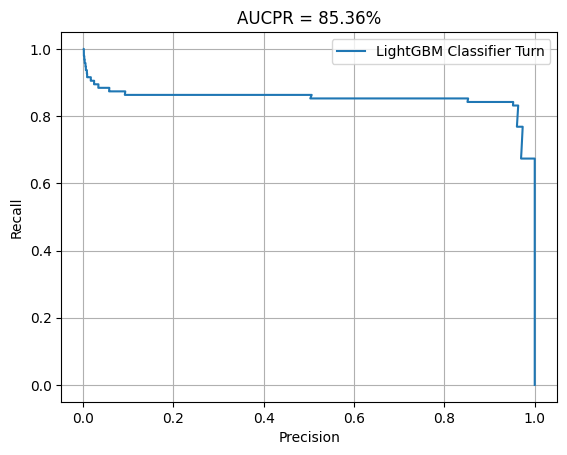

In [ ]:
plot_recall_precision_curve(clf_lgbm_turn, X_val, y_val, name_clf='LightGBM Classifier Turn')

In [ ]:
modelo(clf_lgbm_turn, X_train, y_train, X_test, y_test)

Score Cross Validation: 92.92%
Average Precision: 84.02%
Precision Score: 86.67%
Recall Score: 82.11%
F1 Score: 84.32%
AUCPR: 84.01%
ROC AUC Score: 91.04%


### CatBoost Classifier

In [ ]:
def objective_cat(trial):
    # Definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 6, 400)
    max_depth = trial.suggest_int('max_depth', 3, 14)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 0.90, step=0.05)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.4, 1.0, step=0.05)

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'l2_leaf_reg': l2_leaf_reg,
        'colsample_bylevel': colsample_bylevel,
        'subsample':subsample,
    }

    clf = CatBoostClassifier(**params, auto_class_weights='Balanced', thread_count=-1, verbose=False, random_state=27)
    clf.fit(X_train, y_train)

    score = f1_score(y_val, clf.predict(X_val))
    # score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])

    return score

In [ ]:
study_cat = optuna.create_study(direction = 'maximize')
study_cat.optimize(objective_cat, n_trials=50)

[I 2024-07-28 15:50:55,324] A new study created in memory with name: no-name-dfde5f13-7443-43bb-abb2-732a55758da6
[I 2024-07-28 15:51:13,697] Trial 0 finished with value: 0.24411764705882352 and parameters: {'n_estimators': 312, 'max_depth': 5, 'learning_rate': 0.0016839324892917787, 'l2_leaf_reg': 0.047930924010609464, 'subsample': 0.6, 'colsample_bylevel': 0.8500000000000001}. Best is trial 0 with value: 0.24411764705882352.
[I 2024-07-28 15:59:23,920] Trial 1 finished with value: 0.8241758241758242 and parameters: {'n_estimators': 272, 'max_depth': 14, 'learning_rate': 0.006790653063839386, 'l2_leaf_reg': 0.004980470888512318, 'subsample': 0.6, 'colsample_bylevel': 0.55}. Best is trial 1 with value: 0.8241758241758242.
[I 2024-07-28 16:04:55,400] Trial 2 finished with value: 0.839779005524862 and parameters: {'n_estimators': 282, 'max_depth': 13, 'learning_rate': 0.008802646043395456, 'l2_leaf_reg': 0.02438545920170259, 'subsample': 0.9, 'colsample_bylevel': 0.75}. Best is trial 2 w

In [ ]:
best_params_cat = study_cat.best_params
print(best_params_cat)

{'n_estimators': 368, 'max_depth': 9, 'learning_rate': 0.08832154570307492, 'l2_leaf_reg': 0.09841498647386973, 'subsample': 0.65, 'colsample_bylevel': 0.6000000000000001}


In [ ]:
# Criação do modelo
clf_cat_turn = CatBoostClassifier(
    **best_params_cat,
    auto_class_weights='Balanced',
    thread_count=-1,
    random_state = 27,
    verbose=False)

In [ ]:
modelo(clf_cat_turn, X_train, y_train, X_val, y_val)

Score Cross Validation: 97.11%
Average Precision: 86.32%
Precision Score: 94.19%
Recall Score: 85.26%
F1 Score: 89.50%
AUCPR: 86.30%
ROC AUC Score: 92.63%


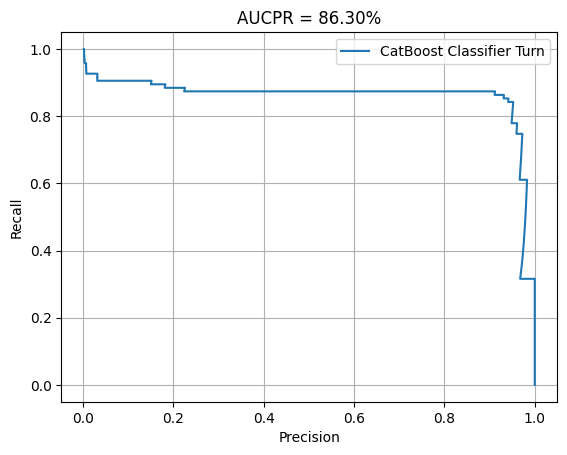

In [ ]:
plot_recall_precision_curve(clf_cat_turn, X_val, y_val, name_clf='CatBoost Classifier Turn')

In [ ]:
modelo(clf_lgbm_turn, X_train, y_train, X_test, y_test)

## 4.3 Escolha do Modelo

In [ ]:
params_model = {
    'n_estimators': 495,
    'max_depth': 13,
    'learning_rate': 0.056660271915512,
    'subsample': 0.8500000000000001,
    'colsample_bytree': 0.55,
    'min_child_weight': 5
    }

model = XGBClassifier(**params_model, scale_pos_weight=weight, random_state=27)

In [ ]:
modelo(model, X_train, y_train, X_test, y_test)

Score Cross Validation: 98.33%
Average Precision: 86.97%
Precision Score: 90.91%
Recall Score: 84.21%
F1 Score: 87.43%
AUCPR: 86.97%
ROC AUC Score: 92.10%


In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.056660271915512,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=495, n_jobs=None,
              num_parallel_tree=None, random_state=27, ...)

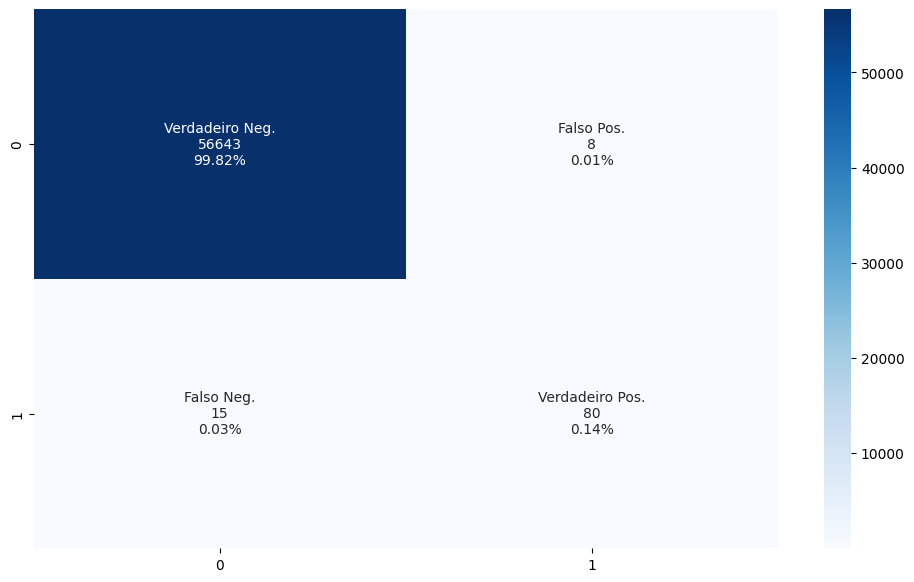

In [ ]:
matriz_confusao(model, X_test, y_test)

# 5. Análise de Negócio

Performance do nosso modelo:

* Score Cross Validation: 98,33%%
* Average Precision: 86,97%
* Precision Score: 90,91%
* Recall Score: 84,21%
* F1 Score: 87,43%
* ROC AUC Score: 92,10%
<br>

Vemos que todas as transações que realmente eram fraudulentas, nosso modelo conseguiu acertar 84,21% dos casos. <br>
Além disso, de todas as transações que o modelo disse eram fraudulentas, ele acertou 90,91%.
<br><br>
<hr>
 <h2>Benefícios da Implantação do Modelo</h2>
<hr>

Agora, de forma simplicada, vamos analisar o impacto que resultaria, se o modelo tivesse sido aplicado. Para isso, precisamos analisar quatro tipos de situações, provenientes da aplicação do modelo:

Sabe-se que, o modelo pode realizar uma previsão corretamente de duas maneiras. Mas, também pode errar de duas maneiras. Cada uma delas, implica em situações distintas para a empresa, como perdas, prevenção de perdas, posíveis ganhos e situação que ela deixou de ganhar.

Agora, vamos analisar uma a uma:
### Situação 01: Previsão correta de transação não fraudulenta
- **Descrição**: O modelo prevê que a transação não é fraudulenta e realmente não é.
- **Impacto**:
  - **Benefício**: A empresa empresta seu capital corretamente, resultando em benefícios futuros através de taxas de juros e satisfação do cliente.
  - **Conclusão**: Previsão correta que promove crescimento e confiança.

### Situação 02: Previsão incorreta de transação fraudulenta
- **Descrição**: O modelo prevê que a transação é fraudulenta, quando na verdade não é.
- **Impacto**:
  - **Perda de Oportunidade**: A empresa não cede crédito, perdendo potenciais receitas de juros e taxas.
  - **Inconveniência ao Cliente**: Pode causar frustração e insatisfação ao cliente, impactando a experiência do cliente.
  - **Conclusão**: Previsão incorreta que não resulta em perda direta, mas sim em perda de oportunidade e potencial insatisfação do cliente.

### Situação 03: Previsão incorreta de transação não fraudulenta
- **Descrição**: O modelo prevê que a transação é normal, quando na verdade é fraudulenta.
- **Impacto**:
  - **Perda Financeira**: A empresa arcará com os custos da fraude, reembolsando o cliente e podendo sofrer perdas significativas.
  - **Riscos Legais e Reputacionais**: Possibilidade de ações judiciais e dano à credibilidade da instituição.
  - **Conclusão**: Previsão incorreta que é crítica, resultando em perdas financeiras diretas e potenciais danos à reputação.

### Situação 04: Previsão correta de transação fraudulenta
- **Descrição**: O modelo prevê que a transação é fraudulenta, e realmente é.
- **Impacto**:
  - **Prevenção de Perdas**: A empresa evita perdas financeiras significativas ao bloquear a transação fraudulenta.
  - **Proteção da Credibilidade**: Mantém a confiança dos clientes e a integridade da instituição.
  - **Conclusão**: Previsão correta que protege a empresa de perdas e promove segurança e confiança.

### Resumo
- **Previsões Correta (Situações 01 e 04)**: Resultam em benefícios diretos e indiretos para a empresa, promovendo crescimento, confiança e segurança.
- **Previsões Incorretas (Situações 02 e 03)**: Resultam em perda de oportunidades (Situação 02) ou perdas diretas e riscos reputacionais (Situação 03).

In [ ]:
X_test_df = X_test_copy.copy()

In [ ]:
y_pred_test = model.predict(X_test)
X_test_df['y_pred'] = y_pred_test
X_test_df['y_true'] = y_test

In [ ]:
# previsão do modelo = não fraudulenta   ;   classe real = fraudulenta
# perdas de oportunidade
situation_02 = X_test_df[(X_test_df['y_pred'] == 1) & (X_test_df['y_true'] == 0)]

In [ ]:
# calcular valor que a empresa deixou de ganhar, assumindo que ela ganharia 10% sobre cada transação
perdas_oportunidade = (situation_02['Amount'] * 0.10).sum()
print(f'Ao rejeitar as transações normais, estariamos perdendo, cerca de R${perdas_oportunidade:,.2f}')

Ao rejeitar as transações normais, estariamos perdendo, cerca de R$31.98


In [ ]:
# previsão do modelo = não fraudulenta   ;   classe real = fraudulenta
# perdas direta
situation_03 = X_test_df[(X_test_df['y_pred'] == 0) & (X_test_df['y_true'] == 1)]

In [ ]:
# calcular valor total perdido
valor_perdido = situation_03['Amount'].sum()

print(f'Estamos perdendo, cerca de, R${valor_perdido:,.2f}')

Estamos perdendo, cerca de, R$3,535.56


In [ ]:
# previsão do modelo = fraudulenta   ;   classe real = fraudulenta
# valor que evitou perder
situation_04 = X_test_df[(X_test_df['y_pred'] == 1) & (X_test_df['y_true'] == 1)]

In [ ]:
# calcular valor total que evitou perder
valor_prevenido = situation_04['Amount'].sum()
print(f'Ao detectar transações fraudulentas, deixamos de perder, cerca de, R${valor_prevenido:,.2f}')

Ao detectar transações fraudulentas, deixamos de perder, cerca de, R$11,447.74


## **Resultado**

Como vimos, a empresa evitaria perder **R$11.447,74** com a detecção de transações frauduletas. <br>

Porém, iríamos perder **R$3.535,56** com os erros do modelo. Além disso, deixamos de ganhar **R\$31,98** com a recusão de crédito. <br>

Sendo assim, teríamos um ganho de **R\$7.880,20**.<br>

Coisa boa, não acha? Evitaríamos perder um valor bem maior que o erro do nosso modelo. Sendo esse, mais um motivo a favor de sua utilização.

Veja, essa análise foi simplicada. Na prática, poderia haver outros custos, como o custo computacional para rodar o modelo. Além disso, o valor ganho sobre cada transação, foi só uma hipótese minha adotada.


